
# Classifying Passive vs. Active Revenge in Related Subreddits using NLP

--- 
# Part 4 : Lemmatizing, Word Vectorizing & EDA

--- 

Since we are dealing with text data and classification of that text, we took steps in previous notebooks to clean and pre-process the data. For example, we removed special characters, removed markdown and html artifacts, and we now will look at possibly tokenizing, lemmatizing, and generic stop word removal on our data. We will then do further exploration of common words found in each of the subreddits as well as additional stop words we may need to remove in order to extract words that are distinguishable between the subreddits to help us classify each one. 

## Contents
- [Tokenizing & Lemmatizing](#Tokenizing-&-Lemmatizing)
- [Word Vectorizing & EDA](#Word-Vectorizing-&-EDA)
- [Summary](#Summary)

## Data Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_selection import chi2
import json

In [2]:
# Read in CSV & create df

df = pd.read_csv('../data/cleaned_subreddit_data.csv')

In [3]:
df.head()

,author,num_comments,score,subreddit,timestamp,all_text
0,Erahth,12,1,MaliciousCompliance,2021-08-01 00:11:01,one more sip so this just happened my 3 5yo so...
1,MorrisonsLament,39,1,MaliciousCompliance,2021-08-01 00:12:45,you can t fire me but you can make me stop wo...
2,infiniteknights,215,1,MaliciousCompliance,2021-08-01 00:21:24,personal responsibility ok i ve been doing al...
3,SimRayB,19,1,MaliciousCompliance,2021-08-01 00:42:46,you put all of those in your mouth or you can ...
4,CSPhCT,28,1,MaliciousCompliance,2021-08-01 06:01:07,patient wants what he wants so i just need to ...


In [4]:
df.shape

(11189, 6)

In [5]:
df.isnull().sum()

author          0
num_comments    0
score           0
subreddit       0
timestamp       0
all_text        0
dtype: int64

In [6]:
df.dtypes

author          object
num_comments     int64
score            int64
subreddit       object
timestamp       object
all_text        object
dtype: object

**Notes:** The 'all_text' column is currently an object. To analyze and classify text, we will need to implement tokenizing, lemmatizing, and possibly stemming before we can vectorize the words into columns where we can count the occurence of words and their importance to classification models.

In [7]:
# Creating separate dfs for each sub in case we need them for any EDA

malicious = df[df['subreddit']=='MaliciousCompliance']
petty = df[df['subreddit']=='pettyrevenge']
pro = df[df['subreddit']=='ProRevenge']

In [8]:
df['subreddit'].value_counts(normalize = True)

MaliciousCompliance    0.473948
pettyrevenge           0.300295
ProRevenge             0.225757
Name: subreddit, dtype: float64

In [9]:
# Combine pettyrevenge and ProRevenge and reclassify each class as active or passive

subs = {'MaliciousCompliance': 'passive', 'pettyrevenge': 'active', 'ProRevenge': 'active',}
df['subreddits'] = df['subreddit']
df = df.replace({'subreddits':subs})

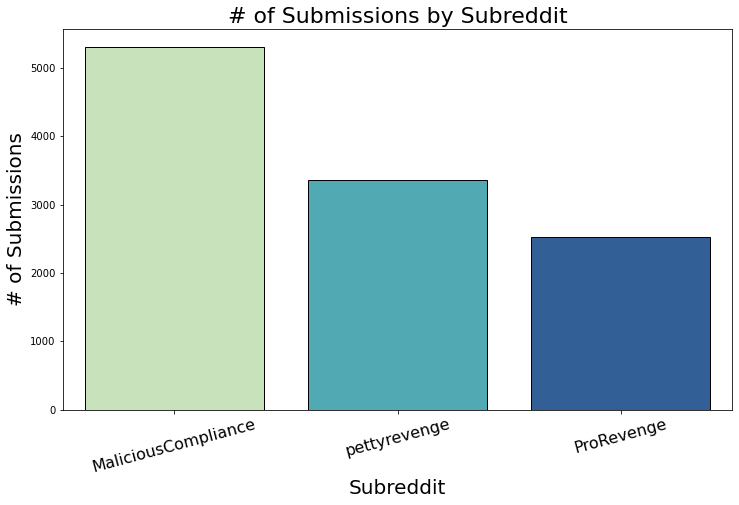

In [10]:
# Amount of submissions belonging to each class

plt.figure(figsize=(12, 7))
sns.countplot(x='subreddit', data=df, ec='k', linewidth=1, palette='YlGnBu')
plt.xticks(rotation=15, fontsize=16)
plt.title('# of Submissions by Subreddit', fontsize=22)
plt.ylabel('# of Submissions', fontsize=20)
plt.xlabel('Subreddit', fontsize=20)

plt.savefig('../images/observations.png')

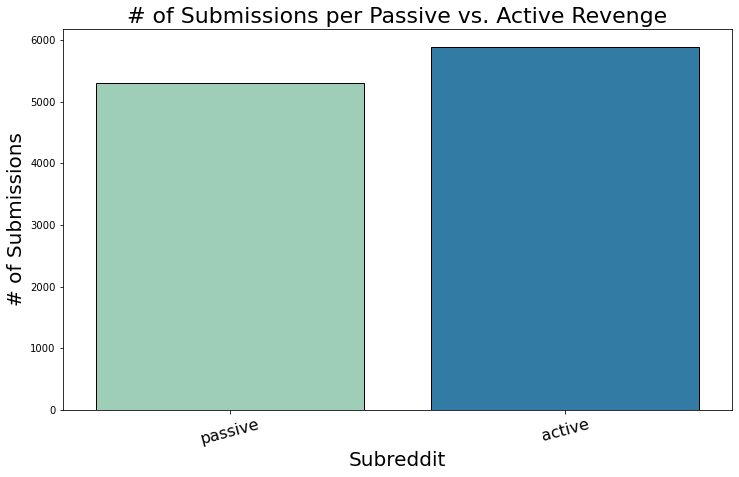

In [11]:
# Amount of submissions belonging to each class

plt.figure(figsize=(12, 7))
sns.countplot(x='subreddits', data=df, ec='k', linewidth=1, palette='YlGnBu')
plt.xticks(rotation=15, fontsize=16)
plt.title('# of Submissions per Passive vs. Active Revenge', fontsize=22)
plt.ylabel('# of Submissions', fontsize=20)
plt.xlabel('Subreddit', fontsize=20)

plt.savefig('../images/observations2.png')

In [12]:
#Number of words in each submission

df['text_length'] = [len(i.split()) for i in df['all_text']]

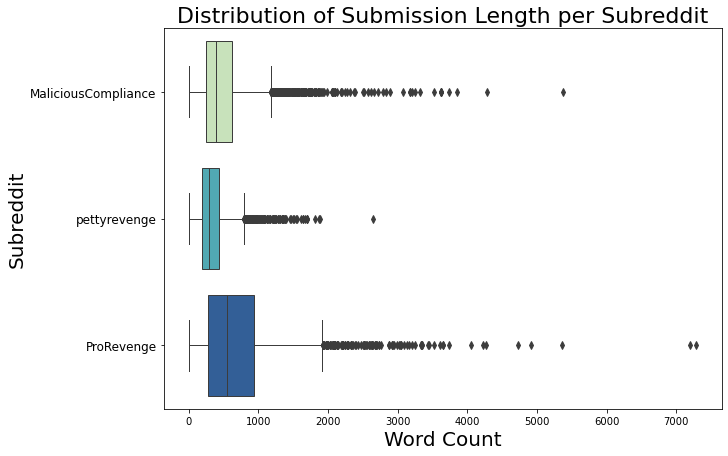

In [13]:
# plot submission length distributions
plt.figure(figsize=(10, 7))
ax = sns.boxplot(x="text_length", y="subreddit", data=df, linewidth=1, palette='YlGnBu', orient="h")
plt.title('Distribution of Submission Length per Subreddit', fontsize=22)
plt.ylabel('Subreddit', fontsize=20)
plt.xlabel('Word Count', fontsize=20)
plt.yticks(fontsize=12)

plt.savefig('../images/sub length.png')

## Tokenizing & Lemmatizing

In [14]:
df['all_text'].head()

0    one more sip so this just happened my 3 5yo so...
1     you can t fire me but you can make me stop wo...
2     personal responsibility ok i ve been doing al...
3    you put all of those in your mouth or you can ...
4    patient wants what he wants so i just need to ...
Name: all_text, dtype: object

In [15]:
# Using list comprehension to loop through strings of text and create lists of words

df['tokens'] = [word_tokenize(text) for text in df['all_text']]

In [16]:
# Checking tokens
df['tokens'].head()

0    [one, more, sip, so, this, just, happened, my,...
1    [you, can, t, fire, me, but, you, can, make, m...
2    [personal, responsibility, ok, i, ve, been, do...
3    [you, put, all, of, those, in, your, mouth, or...
4    [patient, wants, what, he, wants, so, i, just,...
Name: tokens, dtype: object

In [17]:
# Instantiate Lemmatizer

lemmatizer = WordNetLemmatizer()

In [18]:
# Lemmatizing- returning shortened base forms of words and join the words back into a list of strings

nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.loc[row]['all_text']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(lemmatizer.lemmatize(word))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)


df['lems'] = lemmatized_text_list

In [19]:
df['lems'][0]

'one more sip so this just happened my 3 5yo son is showing sign of tiredness and he s just finishing his lunch a part of lunch he ha a 300ml chocolate milk i picked up from the shop cause it wa on clearance and he s been a pretty good boy today he d drunk a little under half and wa just sipping at it and i said to him ok little man one more sip then it s going in the fridge and you re going for quiet time he look me dead in the eye then fully try to neck the rest of the bottle i let him go until he stopped to breathe but he definitely ha the mc streak '

## Word Vectorizing & EDA

In [20]:
# Vectorize
X = df['lems']

In [21]:
# Baseline
df['subreddit'].value_counts(normalize=True)

MaliciousCompliance    0.473948
pettyrevenge           0.300295
ProRevenge             0.225757
Name: subreddit, dtype: float64

In [22]:
# Instantiate a CountVectorizer & remove generic stop words
cvec = CountVectorizer(max_features = 5000,
                       min_df=2,
                       stop_words = 'english',
                       ngram_range = (1,2)
                      )

In [23]:
# Fit & transform the vectorizer
vec_df= pd.DataFrame(cvec.fit_transform(X).todense(), columns=cvec.get_feature_names())

In [24]:
# Checking list of words to see if i need to do any more cleaning - commenting out for space
#cvec.get_feature_names()

### Most Common Words in All Text from 3 Subreddits Combined

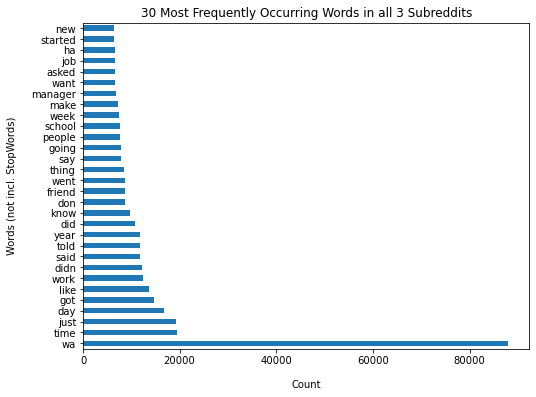

In [25]:
vec_df.sum().sort_values(ascending = False).head(30).plot(kind='barh', figsize=(8, 6))
plt.xlabel("Count", labelpad=14)
plt.ylabel("Words (not incl. StopWords)", labelpad=14)
plt.title("30 Most Frequently Occurring Words in all 3 Subreddits");

### Most Common Words for Each Subreddit

In [26]:
# Vectorizing for each sub
X1 = malicious['all_text']
X2 = petty['all_text']
X3 = pro['all_text']

vec_mal= pd.DataFrame(cvec.fit_transform(X1).todense(), columns=cvec.get_feature_names())
vec_petty= pd.DataFrame(cvec.fit_transform(X2).todense(), columns=cvec.get_feature_names())
vec_pro= pd.DataFrame(cvec.fit_transform(X3).todense(), columns=cvec.get_feature_names())

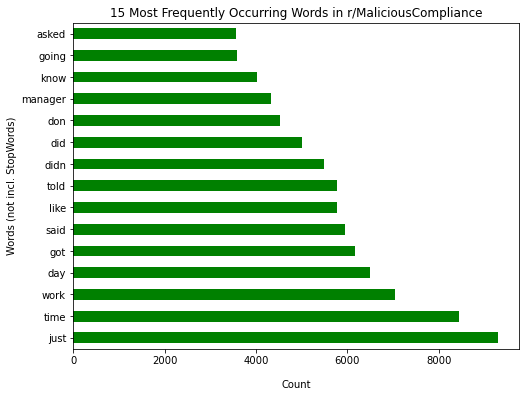

In [27]:
vec_mal.sum().sort_values(ascending = False).head(15).plot(kind='barh', figsize=(8, 6), color = 'green')
plt.xlabel("Count", labelpad=14)
plt.ylabel("Words (not incl. StopWords)")
plt.title("15 Most Frequently Occurring Words in r/MaliciousCompliance");

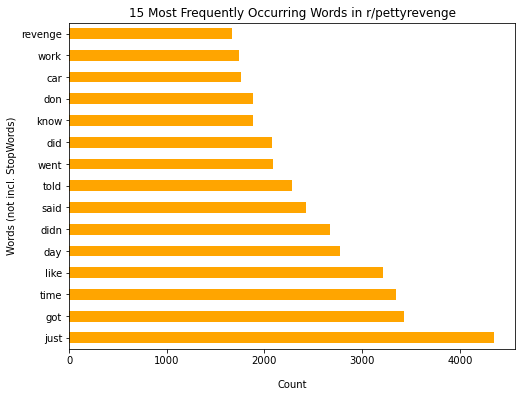

In [28]:
vec_petty.sum().sort_values(ascending = False).head(15).plot(kind='barh', figsize=(8, 6), color = 'orange')
plt.xlabel("Count", labelpad=14)
plt.ylabel("Words (not incl. StopWords)")
plt.title("15 Most Frequently Occurring Words in r/pettyrevenge");

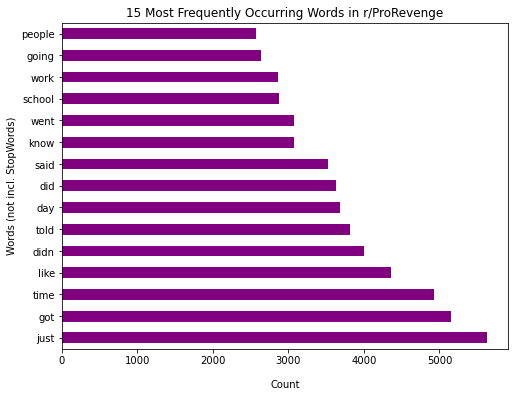

In [29]:
vec_pro.sum().sort_values(ascending = False).head(15).plot(kind='barh', figsize=(8, 6), color = 'purple')
plt.xlabel("Count", labelpad=14)
plt.ylabel("Words (not incl. StopWords)")
plt.title("15 Most Frequently Occurring Words in r/ProRevenge");

### Removing Additional Stopwords
There's a lot of overlap in word frequency between the 3 subreddits. This was an iterative process to keep adding to this list of common words that the 3 subreddits share. I really focused on removing any overlap between r/MaliciousCompliance from the other subreddits. /pettyrevenge and /ProRevenge were allowed to remain with common words since the goal of this project is to differentiate passive from active revenge and those 2 subreddits fall in the active revenge category which we end up combining later. 

In [30]:
# Remove more stop words

my_stopwords = ['none','\n', 'www', 'reddit', 'comment', 'http', '00', '000','10','100','11','12','15','16',
            '18','20','25','30','40','45','50','op', 'just', 'got', 'time', 'like', 'did', 'didn', 'told', 'day', 
            'know', 'said','work', 'way', 'school', 'went', 'goin', 'don', 'going', 'people', 'started', 'asked',
            'make', 'years', 'new', 'really', 'good', 'year', 'revenge', 'petty', 'pany', 'll','wasn', 'came', 
            'later', 'story', 'let', 'say', 'job', 'right', 'home', 'left', 'tell', 'things', 'took', 'dad', 've', 
           'happened', 'getting', 'little', 'want', 'sure', 'pliance', 'minutes', 'wanted', 'class', 'called', 'mom',
               'phone', 'store', 'doing', 'away', 'ago', 'think', 'malicious', 'room', 'lot', 'guy', 'pay', 'decided',
               'thing', 'end', 'knew', 'look', 'long', 'week', 'old', 'night', 'point', 'manager', 'use', 'months',
               'car', 'says', 'days', 'teacher', 'couldn', 'thought', 'person', 'amp', 'big', 'leave', 'place', 
                'money', 'pretty', 'house', 'weeks', 'es', 'having', 'help', 'tried', 'used', 'working', 'bit',
               'friend', 'gave', 'food', 'trying', 'office', 'start', 'face', 'karen', 'small', 'door', 'head', 
                'hours', 'need', 'saying', 'best', 'boss', 'couple', 'bad', 'stuff', 'times', 'looked', 'ask', 'kids',
               'month', 'line', 'actually', 'high', 'worked', 'doesn', 'gets', 'needed', 'better', 'half', 'finally',
               'sent', 'stop', 'wouldn', 'gt', 'ply', 'ag', 'mm']

stop_words = set(stopwords.words("english"))
more_stop_words = stop_words.union(my_stopwords)

In [31]:
len(my_stopwords)

165

## More Word Vectorizing & EDA

In [32]:
# Instantiate another CountVectorizer & remove additional stop words

cvec = CountVectorizer(max_features = 5000,
                       min_df=2,
                       max_df = 0.8,
                       stop_words = more_stop_words,
                       ngram_range = (1,2)
                      )

In [33]:
# Fit & transform the vectorizer

vec_df= pd.DataFrame(cvec.fit_transform(X).todense(), columns=cvec.get_feature_names())

In [34]:
# Vectorizing for each sub
X1 = malicious['all_text']
X2 = petty['all_text']
X3 = pro['all_text']

vec_mal= pd.DataFrame(cvec.fit_transform(X1).todense(), columns=cvec.get_feature_names())
vec_petty= pd.DataFrame(cvec.fit_transform(X2).todense(), columns=cvec.get_feature_names())
vec_pro= pd.DataFrame(cvec.fit_transform(X3).todense(), columns=cvec.get_feature_names())

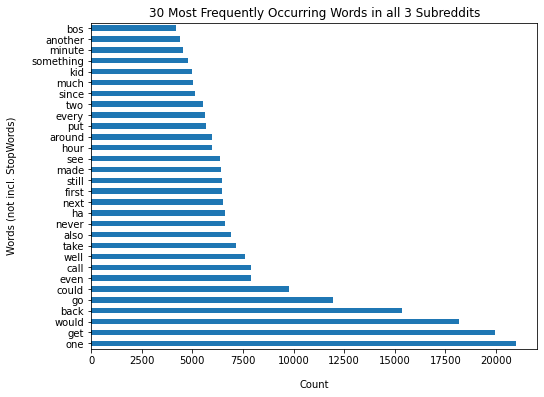

In [35]:
vec_df.sum().sort_values(ascending = False).head(30).plot(kind='barh', figsize=(8, 6))
plt.xlabel("Count", labelpad=14)
plt.ylabel("Words (not incl. StopWords)", labelpad=14)
plt.title("30 Most Frequently Occurring Words in all 3 Subreddits");

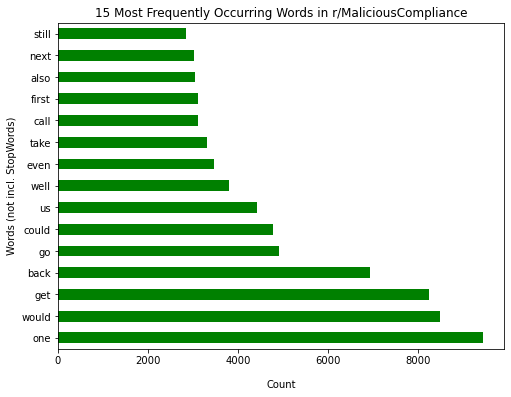

In [36]:
vec_mal.sum().sort_values(ascending = False).head(15).plot(kind='barh', figsize=(8, 6), color = 'green')
plt.xlabel("Count", labelpad=14)
plt.ylabel("Words (not incl. StopWords)")
plt.title("15 Most Frequently Occurring Words in r/MaliciousCompliance");

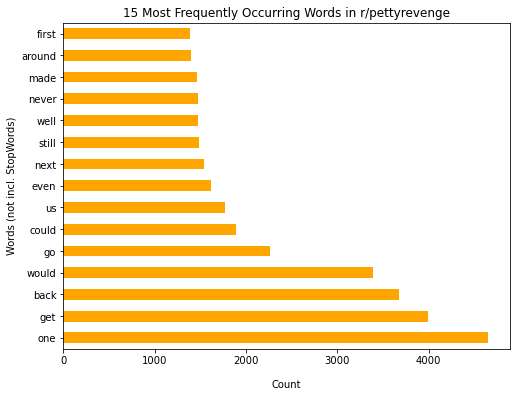

In [37]:
vec_petty.sum().sort_values(ascending = False).head(15).plot(kind='barh', figsize=(8, 6), color = 'orange')
plt.xlabel("Count", labelpad=14)
plt.ylabel("Words (not incl. StopWords)")
plt.title("15 Most Frequently Occurring Words in r/pettyrevenge");

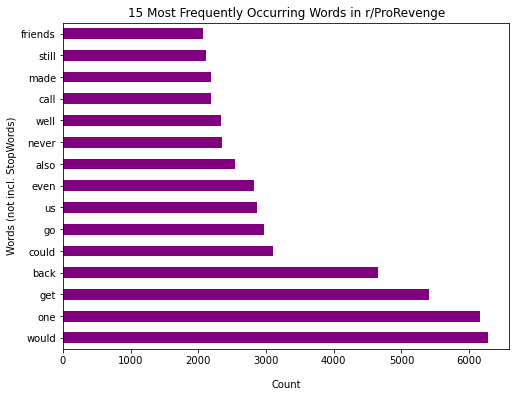

In [38]:
vec_pro.sum().sort_values(ascending = False).head(15).plot(kind='barh', figsize=(8, 6), color = 'purple')
plt.xlabel("Count", labelpad=14)
plt.ylabel("Words (not incl. StopWords)")
plt.title("15 Most Frequently Occurring Words in r/ProRevenge");

In [39]:
#REFERENCE: Gwen's repo
all_common = vec_df.mean().sort_values(ascending=False)[0:150]

mal_words = vec_mal.mean().sort_values(ascending=False)[0:150]

petty_words = vec_petty.mean().sort_values(ascending=False)[0:150]

pro_words = vec_pro.mean().sort_values(ascending=False)[0:150]

/Users/emilysiegel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/emilysiegel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/emilysiegel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

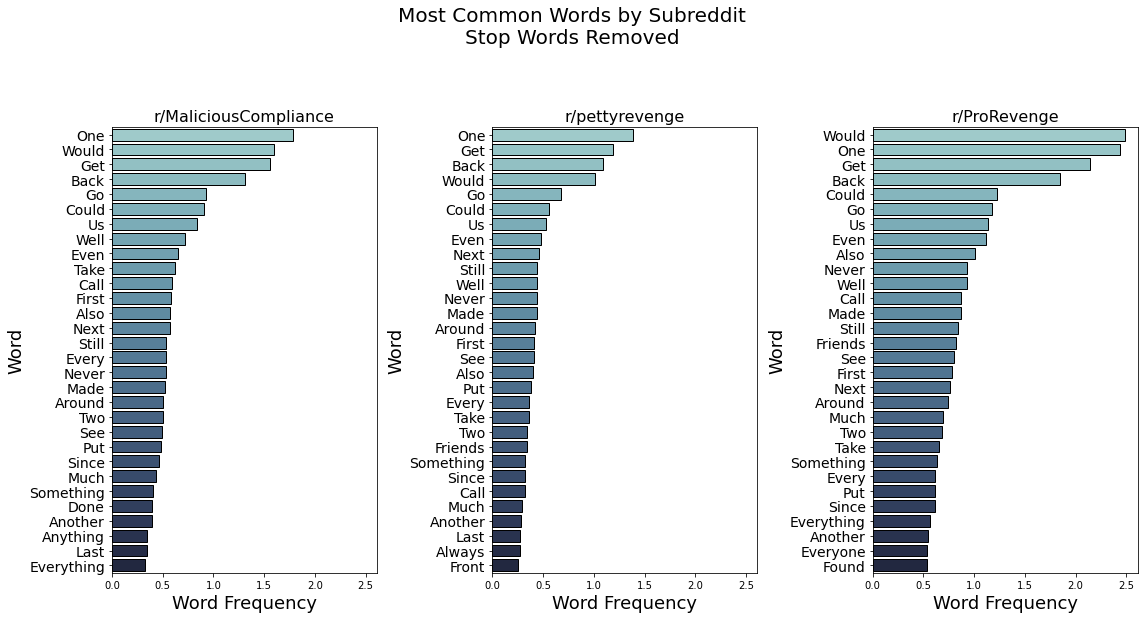

In [40]:
#REFERENCE: Shoutout to Gwen's repo for some of these plot inspirations
tables = [mal_words,petty_words, pro_words]
titles = ['r/MaliciousCompliance','r/pettyrevenge','r/ProRevenge']

fig, ax = plt.subplots(1,3, sharex=True, figsize=(16,8))
axs = ax.ravel()
fig.suptitle('Most Common Words by Subreddit\nStop Words Removed', fontsize=20, y=1.07)
for i, ax in enumerate(axs):
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_title(titles[i], fontsize=16)
    ax.set_xlabel('Word Frequency', fontsize=18)
    ax.set_ylabel('Word', fontsize=18)
    sns.barplot(tables[i][0:30],tables[i].index.str.title()[0:30], orient='h',ax=ax, ec='k', linewidth=1, palette="ch:rot=-.25,hue=1,light=.75")
fig.tight_layout()

plt.savefig('../images/common words.png')

In [41]:
mal_freq = vec_mal.mean() - (vec_petty.mean() + vec_pro.mean())
words_mal = mal_freq.dropna().sort_values(ascending=False)

other_freq = (vec_petty.mean() + vec_pro.mean()) - vec_mal.mean()
words_other = other_freq.dropna().sort_values(ascending=False)

/Users/emilysiegel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/emilysiegel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


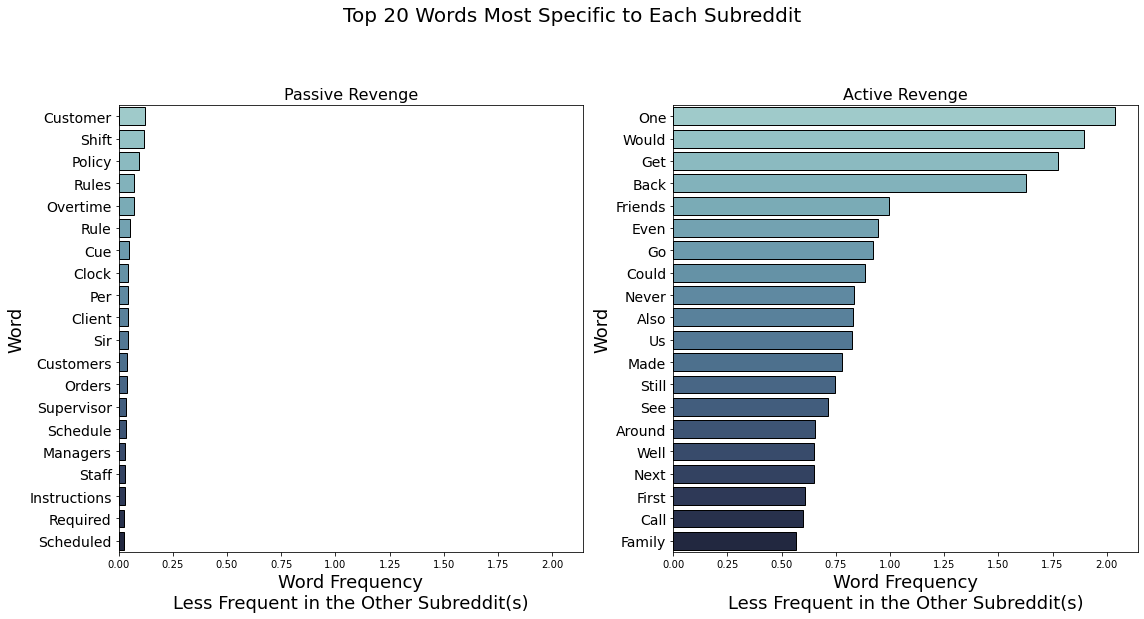

In [42]:
tables = [words_mal,words_other]
titles = ['Passive Revenge','Active Revenge']

fig, ax = plt.subplots(1,2, sharex=True, figsize=(16,8))
axs = ax.ravel()
fig.suptitle('Top 20 Words Most Specific to Each Subreddit', fontsize=20, y=1.07)
for i, ax in enumerate(axs):
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_title(titles[i], fontsize=16)
    ax.set_xlabel('Word Frequency\nLess Frequent in the Other Subreddit(s)', fontsize=18)
    ax.set_ylabel('Word', fontsize=18)
    sns.barplot(tables[i][0:20],tables[i].index.str.title()[0:20], orient='h',ax=ax, ec='k', linewidth=1, palette="ch:rot=-.25,hue=1,light=.75")
fig.tight_layout()

plt.savefig('../images/word_freq.png')

In [43]:
# REFERENCE: https://stackoverflow.com/questions/7100125/storing-python-dictionaries
# Save our stop words as a list then dict then json file

stopwords_dict = {'words': list(more_stop_words)}

In [44]:
json.dump(stopwords_dict, open('../data/more_stopwords.json', 'w'))
stopwords_dict = json.load(open('../data/more_stopwords.json'))

In [45]:
# Save preprocessed df as csv

df.to_csv('../data/preprocessed_cleaned_subreddit_data.csv', index=False)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11189 entries, 0 to 11188
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   author        11189 non-null  object
 1   num_comments  11189 non-null  int64 
 2   score         11189 non-null  int64 
 3   subreddit     11189 non-null  object
 4   timestamp     11189 non-null  object
 5   all_text      11189 non-null  object
 6   subreddits    11189 non-null  object
 7   text_length   11189 non-null  int64 
 8   tokens        11189 non-null  object
 9   lems          11189 non-null  object
dtypes: int64(3), object(7)
memory usage: 874.3+ KB


## Summary

Words were lemmatized and generic stop words were removed. Since there was quite a bit of overlap in common words between the 3 subreddit, 165 custom stop words were also removed. An analysis of the most frequently occuring words in each subreddit class (and less frequent in the other respective class) was completed. This process of cleaning our text features is important to avoid overfitting our model. There are enough differences in content between the Passive vs. Active subreddits to continue on with the modeling phase. 